# Bike and Car Accident Statistical Analysis #

In this notebook, I will look at my database of car and bike accidents and see if I can see a statistically significant difference between density of accidents in areas with:

1. Different speed limits
2. Different facility designations
3. Different numbers of lanes--I'll see if I can control for speed limit here, since they are linked
4. Truck exclusion type
5. Surface Types

## Speed Limits ##

In [18]:
import pandas as pd
import numpy as np
import math
import scipy.stats
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t

In [3]:
# read in road database since that's where speed limit is
rd = pd.read_csv('data/cleaned_data/road_qualities.csv').drop(columns=['Unnamed: 0'])

In [4]:
# limit data to rows with a rational speed limit listed
sl_rd = rd.query('Speed_Lim > 0 and Speed_Lim < 99')
sl_rd.Speed_Lim.describe()

count    23458.000000
mean        30.981541
std          6.822917
min         10.000000
25%         30.000000
50%         30.000000
75%         30.000000
max         55.000000
Name: Speed_Lim, dtype: float64

Text(0, 0.5, 'Bike Accident Density')

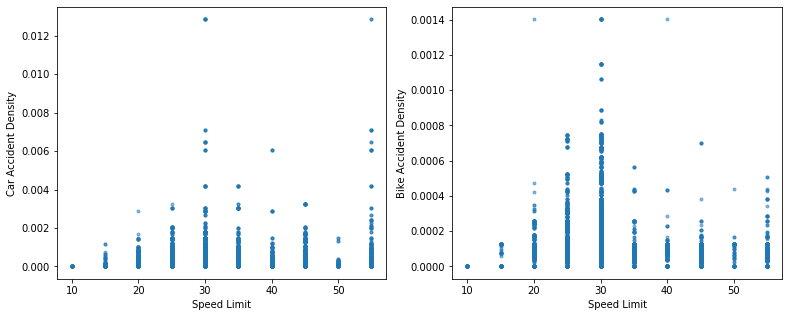

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13.0, 5.0))
ax0.plot(sl_rd.Speed_Lim, sl_rd.car_dens_score, alpha=0.5, linestyle='none', marker='.')
ax0.set_xlabel('Speed Limit')
ax0.set_ylabel('Car Accident Density')
ax1.plot(sl_rd.Speed_Lim, sl_rd.bike_dens_score, alpha=0.5, linestyle='none', marker='.')
ax1.set_xlabel('Speed Limit')
ax1.set_ylabel('Bike Accident Density')

**Hypothesis:** the mean car accident density increases from 10 mph to 30 mph, as does mean bike accident density

I have to break this into several steps to analyze it. First lets count number of accidents at different speed limits. I suspect there aren't enough data points at 10 mph to be worth examining.

Then I need to compare 15 to 20, 20 to 25, 25 to 30. 

The null hypotheses will be that there is no difference.

In [17]:
sl_rd.groupby('Speed_Lim').count()[['car_dens_score', 'bike_dens_score']]

,car_dens_score,bike_dens_score
Speed_Lim,,
10,15,15
15,93,93
20,1253,1253
25,3698,3698
30,13445,13445
35,2189,2189
40,828,828
45,1154,1154
50,74,74


Yep, not very many at 10 or 15. So I'll concentrate on 20, 25, and 30.

In [22]:
comp_sl = [(20, 25), (25, 30), (20, 30)]
for i in range(len(comp_sl)):
    t_res = scipy.stats.ttest_ind(sl_rd[sl_rd.Speed_Lim == comp_sl[i][0]].car_dens_score, 
                                       sl_rd[sl_rd.Speed_Lim == comp_sl[i][1]].car_dens_score, 
                                      equal_var=False)
    print('The p-value for rejecting the null hypothesis that there is no difference between car accidents in ' 
          + str(comp_sl[i][0]) + ' mph zones and ' + str(comp_sl[i][1]) + ' mph zones is ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there is no difference between car accidents in 20 mph zones and 25 mph zones is 0.6194128637093077
The p-value for rejecting the null hypothesis that there is no difference between car accidents in 25 mph zones and 30 mph zones is 0.30865801123196035
The p-value for rejecting the null hypothesis that there is no difference between car accidents in 20 mph zones and 30 mph zones is 0.17800797560867979


In [23]:
comp_sl = [(20, 25), (25, 30), (20, 30)]
for i in range(len(comp_sl)):
    t_res = scipy.stats.ttest_ind(sl_rd[sl_rd.Speed_Lim == comp_sl[i][0]].bike_dens_score, 
                                       sl_rd[sl_rd.Speed_Lim == comp_sl[i][1]].bike_dens_score, 
                                      equal_var=False)
    print('The p-value for rejecting the null hypothesis that there is no difference between bike accidents in ' 
          + str(comp_sl[i][0]) + ' mph zones and ' + str(comp_sl[i][1]) + ' mph zones is ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there is no difference between bike accidents in 20 mph zones and 25 mph zones is 0.0009764585459075452
The p-value for rejecting the null hypothesis that there is no difference between bike accidents in 25 mph zones and 30 mph zones is 0.0006733426655266123
The p-value for rejecting the null hypothesis that there is no difference between bike accidents in 20 mph zones and 30 mph zones is 9.245160606207875e-11


The statistical evidence for higher speed limits between 20 and 30 making a difference in accident density is much stronger for bikes than for cars.

## Facility Designations ##

There are several qualitative designations that have to do with the road type and usage, including Facility, F_Class, F_F_Class, NHS, Control

We see larger numbers of car accidents for Facility Types: 3 = Tunnel 7 = Simple ramp 11 = Simple ramp - tunnel

We see larger numbers of bike accidents for the above types and:

4 = Doubledeck 5 = Rotary 10 = Collector - Distributor 12 = Bicycle

In this case, it might be interesting to compare the mean for the various facility types to the mean of the whole data set. I assigned -1 to places where the facility type isn't designated.

For this I will want to use a one-sided t-test since I'm only interested in whe"ther the facility has larger scores.

In [24]:
rd.groupby('Facility').car_acc_score.count()

Facility
-1      8385
 1     60384
 3       601
 4       133
 5       316
 7      2810
 10       34
 11      463
 12      996
Name: car_acc_score, dtype: int64

In [33]:
fac_types = np.array(rd.groupby('Facility').car_acc_score.count().index)[1:]


array([ 1,  3,  4,  5,  7, 10, 11, 12], dtype=int64)

In [44]:
for i in range(len(fac_types)):
    if (rd[rd.Facility > 0].car_dens_score.mean() < rd[rd.Facility == fac_types[i]].car_dens_score.mean()):
        t_res = scipy.stats.ttest_ind(rd[rd.Facility == fac_types[i]].car_dens_score, 
                                      rd[rd.Facility > 0].car_dens_score,
                                          equal_var=False)
        print('The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type '
              + str(fac_types[i]) + ' is ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type 3 is 3.674102614864587e-23
The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type 4 is 8.278047634857927e-06
The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type 5 is 0.01152538958510564
The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type 7 is 4.264566336077216e-58
The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type 10 is 0.00043851735986237897
The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type 11 is 7.456235993547622e-25
The p-value for rejecting the null hypothesis that there are the same density of car accidents in Facility Type 12 is 9.19525379130795e-08


This shows me that the Facility type has a strong influence on the number of accidents. 

In [46]:
for i in range(len(fac_types)):
    if (rd[rd.Facility > 0].bike_dens_score.mean() < rd[rd.Facility == fac_types[i]].bike_dens_score.mean()):
        t_res = scipy.stats.ttest_ind(rd[rd.Facility == fac_types[i]].bike_dens_score, 
                                      rd[rd.Facility > 0].bike_dens_score,
                                          equal_var=False)
        print('The p-value for rejecting the null hypothesis that there are the same density of bike accidents in Facility Type '
              + str(fac_types[i]) + ' is ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there are the same density of bike accidents in Facility Type 3 is 0.002207886923264796
The p-value for rejecting the null hypothesis that there are the same density of bike accidents in Facility Type 4 is 0.5434977046476208
The p-value for rejecting the null hypothesis that there are the same density of bike accidents in Facility Type 7 is 0.16771025769564266
The p-value for rejecting the null hypothesis that there are the same density of bike accidents in Facility Type 11 is 0.0012278440790682908
The p-value for rejecting the null hypothesis that there are the same density of bike accidents in Facility Type 12 is 3.195058434203808e-05


We get strong support for the idea that Facility Type affects the density of both car and bike accidents.

## Number of Lanes ##

Number of lanes and speed limit are not independent from one another. So it might be instructive to pick only areas with 30 mph speed limit and see if the number of lanes has an effect.

In [48]:
sl_rd_30 = sl_rd.query('Speed_Lim == 30')
sl_rd_30.groupby('Num_Lanes').count().car_dens_score

Num_Lanes
0        7
1      679
2    10052
3     1326
4     1367
5       14
Name: car_dens_score, dtype: int64

In [51]:
for i in range(1, 5):
    if (sl_rd_30.car_dens_score.mean() < sl_rd_30[sl_rd_30.Num_Lanes == i].car_dens_score.mean()):
        t_res = scipy.stats.ttest_ind(sl_rd_30.car_dens_score, 
                                      sl_rd_30[sl_rd_30.Num_Lanes == i].car_dens_score,
                                          equal_var=False)
        print('The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with '
              + str(i) + ' lanes is ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with 1 lanes is 0.0869741824891845
The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with 3 lanes is 2.3574813067808978e-05
The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with 4 lanes is 0.24898312431260922


In [52]:
for i in range(1, 5):
    if (sl_rd_30.bike_dens_score.mean() < sl_rd_30[sl_rd_30.Num_Lanes == i].bike_dens_score.mean()):
        t_res = scipy.stats.ttest_ind(sl_rd_30.bike_dens_score, 
                                      sl_rd_30[sl_rd_30.Num_Lanes == i].bike_dens_score,
                                          equal_var=False)
        print('The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with '
              + str(i) + ' lanes is ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with 1 lanes is 0.11205769939638383
The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with 3 lanes is 0.1875886974313577
The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with 4 lanes is 0.008982259678217568


This seems to indicate that 1 and 3 lane roads are more dangerous for cars, and 4 lane roads are more dangerous for bikes, at least when the speed limit is 30 mph.

## Truck Exclusion ##

Tbe vast majority of roads have no truck exclusions, but we have around 5000 with some kind of exclusion. For this analysis, I will compare having no exclusion to having any kind of exclusion.

In [53]:
rd.groupby('T_Exc_Type').car_acc_score.count()

T_Exc_Type
-1      3035
 1     66485
 2      2273
 10       20
 12     1122
 13     1187
Name: car_acc_score, dtype: int64

In [61]:
rd.groupby('T_Exc_Type').car_dens_score.mean()

T_Exc_Type
-1     0.000268
 1     0.000143
 2     0.000083
 10    0.000093
 12    0.000303
 13    0.000046
Name: car_dens_score, dtype: float64

In [60]:
t_car_truck = scipy.stats.ttest_ind(rd[rd.T_Exc_Type == 1].car_dens_score, 
                                      rd.query('T_Exc_Type > 1 and T_Exc_Type != 12').car_dens_score,
                                          equal_var=False)
print('The p-value for rejecting the null hypothesis that truck exclusion does not affect density of car accidents is ' 
     + str(t_car_truck.pvalue))

The p-value for rejecting the null hypothesis that truck exclusion does not affect density of car accidents is 4.416851617075955e-172


Truck Exclusion Type 12 means it's a hazardous truck route, so it probably has more truck traffic, and it has a higher mean accident density.

In [62]:
t_car_truck = scipy.stats.ttest_ind(rd[rd.T_Exc_Type == 1].car_dens_score, 
                                      rd[rd.T_Exc_Type == 12].car_dens_score,
                                          equal_var=False)
print('The p-value for rejecting the null hypothesis that hazardous trucks do not affect density of car accidents is ' 
     + str(t_car_truck.pvalue))

The p-value for rejecting the null hypothesis that hazardous trucks do not affect density of car accidents is 5.0490771546803595e-33


Repeating all this for bikes:

In [64]:
rd.groupby('T_Exc_Type').bike_dens_score.mean()

T_Exc_Type
-1     0.000075
 1     0.000076
 2     0.000061
 10    0.000022
 12    0.000074
 13    0.000037
Name: bike_dens_score, dtype: float64

In [65]:
t_bike_truck = scipy.stats.ttest_ind(rd[rd.T_Exc_Type == 1].bike_dens_score, 
                                      rd.query('T_Exc_Type > 1 and T_Exc_Type != 12').bike_dens_score,
                                          equal_var=False)
print('The p-value for rejecting the null hypothesis that truck exclusion does not affect density of bike accidents is ' 
     + str(t_bike_truck.pvalue))

The p-value for rejecting the null hypothesis that truck exclusion does not affect density of bike accidents is 4.4038576516779573e-69


In [66]:
t_bike_truck = scipy.stats.ttest_ind(rd[rd.T_Exc_Type == 1].bike_dens_score, 
                                      rd[rd.T_Exc_Type == 12].bike_dens_score,
                                          equal_var=False)
print('The p-value for rejecting the null hypothesis that hazardous trucks do not affect density of bike accidents is ' 
     + str(t_bike_truck.pvalue))

The p-value for rejecting the null hypothesis that hazardous trucks do not affect density of bike accidents is 0.25133728012812245


It looks like the presence of hazardous trucks does not affect bike accidents as much as cars. This makes sense because roads that allow hazardous trucks are not usually bike routes. 

## Surface Type ##

The data for surface types is not very good, but we do have some. -1 and 0 stand for unknown. Otherwise:
1 = unimproved, graded earth or soil surface road
2 = gravel or stone road
3 = brick road
4 = block road
5 = surface-treated road
6 = bituminous concrete road
7 = portland cement concrete road
8 = Composite road, felxible over rigid
9 = Composite road, rigid over flexible or rigid ('white topping')
10 = Stone dust

In [67]:
rd.groupby('Surface_Tp').car_acc_score.count()

Surface_Tp
-1      2051
 0      8743
 1        49
 2       960
 3        73
 4       392
 5      7895
 6     53584
 7       337
 8        34
 9         1
 10        3
Name: car_acc_score, dtype: int64

Only 2, 4, 5, 6, and 7 have much representation at all. Since 6 is the most common, I will compare the others to that.

In [68]:
rd.groupby('Surface_Tp').car_dens_score.mean()

Surface_Tp
-1     0.000209
 0     0.000161
 1     0.000076
 2     0.000055
 3     0.000104
 4     0.000137
 5     0.000064
 6     0.000156
 7     0.000196
 8     0.000050
 9     0.000000
 10    0.000131
Name: car_dens_score, dtype: float64

In [70]:
for i in [2, 4, 5, 7]:
    t_res = scipy.stats.ttest_ind(rd[rd.Surface_Tp == 6].car_dens_score, 
                                      rd[rd.Surface_Tp == i].car_dens_score,
                                          equal_var=False)
    print('The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with '
              + str(i) + ' surface type  ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with 2 surface type  1.5752569290492361e-155
The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with 4 surface type  0.08300383548899373
The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with 5 surface type  1.459889886623802e-284
The p-value for rejecting the null hypothesis that there are the same density of car accidents on roads with 7 surface type  0.03129269991028368


Types 2, 5 and 7 have a statistically significant difference, with 7, Portland Cement, being worse, and the others being better.

Now for bikes.

In [71]:
for i in [2, 4, 5, 7]:
    t_res = scipy.stats.ttest_ind(rd[rd.Surface_Tp == 6].bike_dens_score, 
                                      rd[rd.Surface_Tp == i].bike_dens_score,
                                          equal_var=False)
    print('The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with '
              + str(i) + ' surface type is ' + str(t_res.pvalue))

The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with 2 surface type is 6.0907638396578336e-43
The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with 4 surface type is 0.6033852691864727
The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with 5 surface type is 2.7094755100577365e-181
The p-value for rejecting the null hypothesis that there are the same density of bike accidents on roads with 7 surface type is 0.0038848096056272713


Similar results as for cars. For more discussion of these results, see The Milestone Report (coming soon).